# Baseline Model using Opcode N Gram

## Set up

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, f1_score


In [3]:
PATH = Path.cwd().parents[2]
DATA_PATH = os.path.join(PATH, 'data/processed/opcode_n_grams')

## List Traditional ML model to compare

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

models = {
  # MultiOutputClassifier Wrappers
  "MultiOutputClassifier(LogisticRegression())": MultiOutputClassifier(LogisticRegression()),
  "MultiOutputClassifier(DecisionTreeClassifier())": MultiOutputClassifier(DecisionTreeClassifier()),
  "MultiOutputClassifier(RandomForestClassifier())": MultiOutputClassifier(RandomForestClassifier()),
  "MultiOutputClassifier(AdaBoostClassifier())": MultiOutputClassifier(AdaBoostClassifier()),
  "MultiOutputClassifier(ExtraTreesClassifier())": MultiOutputClassifier(ExtraTreesClassifier()),
  "MultiOutputClassifier(XGBClassifier())": MultiOutputClassifier(XGBClassifier()),
  "MultiOutputClassifier(LGBMClassifier())": MultiOutputClassifier(LGBMClassifier()),
  "MultiOutputClassifier(SVC())": MultiOutputClassifier(SVC()),
  "MultiOutputClassifier(GaussianNB())": MultiOutputClassifier(GaussianNB()),
  "MultiOutputClassifier(KNeighborsClassifier())": MultiOutputClassifier(KNeighborsClassifier()),
  "MultiOutputClassifier(SGDClassifier())": MultiOutputClassifier(SGDClassifier()),
  "MultiOutputClassifier(MLPClassifier())": MultiOutputClassifier(MLPClassifier()),

  # OneVsRestClassifier Wrappers
  "OneVsRestClassifier(LogisticRegression())": OneVsRestClassifier(LogisticRegression()),
  "OneVsRestClassifier(DecisionTreeClassifier())": OneVsRestClassifier(DecisionTreeClassifier()),
  "OneVsRestClassifier(RandomForestClassifier())": OneVsRestClassifier(RandomForestClassifier()),
  "OneVsRestClassifier(AdaBoostClassifier())": OneVsRestClassifier(AdaBoostClassifier()),
  "OneVsRestClassifier(ExtraTreesClassifier())": OneVsRestClassifier(ExtraTreesClassifier()),
  "OneVsRestClassifier(XGBClassifier())": OneVsRestClassifier(XGBClassifier()),
  "OneVsRestClassifier(LGBMClassifier())": OneVsRestClassifier(LGBMClassifier()),
  "OneVsRestClassifier(SVC())": OneVsRestClassifier(SVC()),
  "OneVsRestClassifier(GaussianNB())": OneVsRestClassifier(GaussianNB()),
  "OneVsRestClassifier(KNeighborsClassifier())": OneVsRestClassifier(KNeighborsClassifier()),
  "OneVsRestClassifier(SGDClassifier())": OneVsRestClassifier(SGDClassifier()),
  "OneVsRestClassifier(MLPClassifier())": OneVsRestClassifier(MLPClassifier()),
}

## Load Dataset

In [5]:
df = pd.read_csv(os.path.join(DATA_PATH, 'dataset.csv')).set_index('address')

with open(os.path.join(DATA_PATH, 'features.json'), "r") as f:
    features = json.load(f)

with open(os.path.join(DATA_PATH, 'labels.json'), "r") as f:
    labels = json.load(f)

In [6]:
df.head()

,mint,leak,limit,add add,add add mstore,add add swap,add and,add and dup,add calldataload,add calldataload push,...,unknown log push,unknown push,unknown push dup,unknown push push,unknown slt,unknown slt sha,unknown swap,unknown swap dup,unknown unknown,unknown unknown unknown
address,,,,,,,,,,,,,,,,,,,,,
0x93023f1d3525e273f291b6f76d2f5027a39bf302,1,0,1,1,1,0,0,0,4,0,...,1,0,0,0,1,1,0,0,0,0
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1,3,0,3,0,0,2,0,...,1,0,0,0,1,1,0,0,6,4
0x94b7d24552933f50a5a5705c446528806dcea381,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0,0,0,0,4,3,0,0,...,1,0,0,0,1,1,0,0,3,1
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,1,0,1,4,0,2,4,3,1,1,...,1,1,0,1,1,1,0,0,0,0


In [7]:
features[:5]

['add add', 'add add mstore', 'add add swap', 'add and', 'add and dup']

In [8]:
labels[:5]

['mint', 'leak', 'limit']

## Prepare Features and Labels

In [9]:
X = df[features]
y = df[labels]

## Train/Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Run all models and collect reports

In [11]:
report_list = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Generate classification report (as dict)
    report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    # Average scores across all labels (macro average)
    avg_scores = report_dict["macro avg"]

    report_list.append({
        "Model": name,
        "Precision": avg_scores["precision"],
        "Recall": avg_scores["recall"],
        "F1-score": avg_scores["f1-score"]
    })


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14, number of negative: 41
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6069
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 663
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.254545 -> initscore=-1.074515
[LightGBM] [Info] Start training from score -1.074515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

## Show report

In [12]:
df_report = pd.DataFrame(report_list)
df_report = df_report.sort_values("F1-score", ascending=False).reset_index(drop=True)
df_report


,Model,Precision,Recall,F1-score
0,OneVsRestClassifier(RandomForestClassifier()),0.944444,0.574074,0.711111
1,MultiOutputClassifier(XGBClassifier()),0.916667,0.574074,0.704762
2,OneVsRestClassifier(XGBClassifier()),0.916667,0.574074,0.704762
3,OneVsRestClassifier(GaussianNB()),0.821429,0.462963,0.575000
4,MultiOutputClassifier(GaussianNB()),0.821429,0.462963,0.575000
5,MultiOutputClassifier(LGBMClassifier()),0.626984,0.518519,0.563889
6,OneVsRestClassifier(LGBMClassifier()),0.626984,0.518519,0.563889
7,MultiOutputClassifier(RandomForestClassifier()),0.822222,0.370370,0.505291
8,OneVsRestClassifier(MLPClassifier()),0.785714,0.388889,0.478571
9,OneVsRestClassifier(ExtraTreesClassifier()),0.888889,0.314815,0.439683


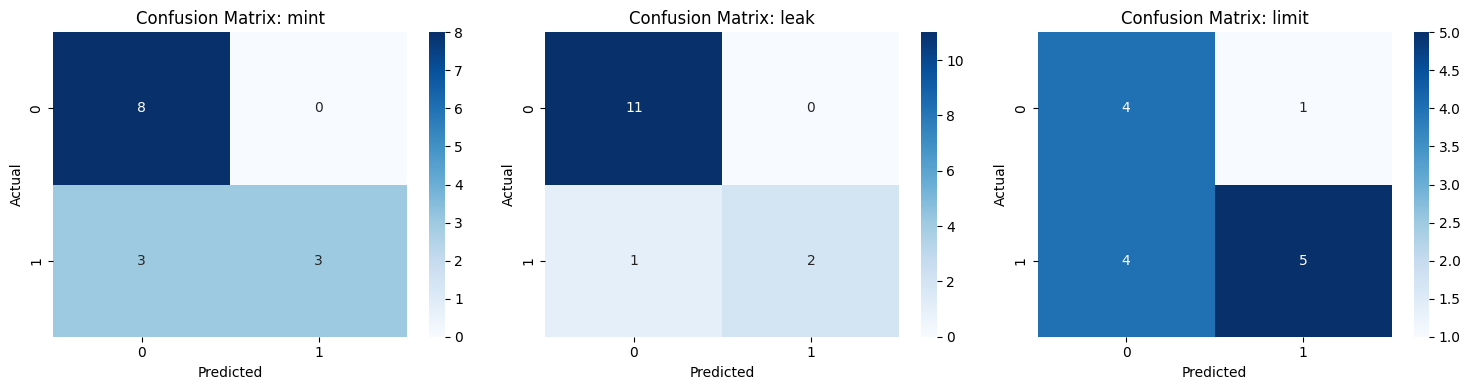

In [13]:
best_model = models[df_report['Model'][0]]
y_pred = best_model.predict(X_test)

def display_multilabel_confusion_matrix(y_test, y_pred):
    # Ensure y_test and y_pred are binary numeric arrays
    y_test_array = np.array(y_test, dtype=int)
    y_pred_array = np.array(y_pred, dtype=int)

    # Generate multi-label confusion matrix again using numeric arrays
    conf_matrices_fixed = multilabel_confusion_matrix(y_test_array, y_pred_array)

    # Plot each confusion matrix again to confirm it's fixed
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for i, (cm, label) in enumerate(zip(conf_matrices_fixed, y.columns)):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix: {label}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

display_multilabel_confusion_matrix(y_test, y_pred)

In [14]:
labels = y.columns.tolist()  # assuming y is a pandas DataFrame

for i, label in enumerate(labels):
    report_dict = classification_report(y_test[label], y_pred[:, i], output_dict=True)
    f1 = report_dict["macro avg"]["f1-score"]
    print(f"{label}, f1-score: {f1}")

mint, f1-score: 0.7543859649122806
leak, f1-score: 0.8782608695652174
limit, f1-score: 0.641025641025641


## Tuning

In [15]:
def get_estimator(trial, base):
    match base:
        case "LogisticRegression":
            return LogisticRegression(
                C=trial.suggest_float("C", 1e-4, 10.0, log=True),
                max_iter=trial.suggest_int("max_iter", 100, 1000),
                solver="lbfgs",
                random_state=42
            )

        case "DecisionTreeClassifier":
            return DecisionTreeClassifier(
                max_depth=trial.suggest_int("max_depth", 3, 20),
                min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
                min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
                random_state=42
            )

        case "RandomForestClassifier":
            return RandomForestClassifier(
                n_estimators=trial.suggest_int("n_estimators", 50, 300),
                max_depth=trial.suggest_int("max_depth", 3, 20),
                min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
                min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
                random_state=42,
                n_jobs=-1
            )

        case "AdaBoostClassifier":
            return AdaBoostClassifier(
                n_estimators=trial.suggest_int("n_estimators", 50, 300),
                learning_rate=trial.suggest_float("learning_rate", 1e-6, 1e-1),
                random_state=42
            )

        case "ExtraTreesClassifier":
            return ExtraTreesClassifier(
                n_estimators=trial.suggest_int("n_estimators", 50, 300),
                max_depth=trial.suggest_int("max_depth", 3, 20),
                min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
                min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
                random_state=42,
                n_jobs=-1
            )

        case "XGBClassifier":
            return XGBClassifier(
                n_estimators=trial.suggest_int("n_estimators", 50, 300),
                max_depth=trial.suggest_int("max_depth", 3, 20),
                learning_rate=trial.suggest_float("learning_rate", 1e-6, 1e-1),
                subsample=trial.suggest_float("subsample", 0.5, 1.0),
                colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
                use_label_encoder=False,
                eval_metric="logloss",
                random_state=42,
                n_jobs=-1
            )

        case "LGBMClassifier":
            return LGBMClassifier(
                n_estimators=trial.suggest_int("n_estimators", 50, 300),
                max_depth=trial.suggest_int("max_depth", 3, 20),
                learning_rate=trial.suggest_float("learning_rate", 1e-6, 1e-1),
                subsample=trial.suggest_float("subsample", 0.5, 1.0),
                colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
                random_state=42,
                n_jobs=-1
            )

        case "SVC":
            return SVC(
                C=trial.suggest_float("C", 0.1, 10.0),
                kernel=trial.suggest_categorical("kernel", ["linear", "rbf", "poly"]),
                gamma=trial.suggest_categorical("gamma", ["scale", "auto"]),
                probability=True
            )

        case "GaussianNB":
            return GaussianNB()  # No major hyperparameters to tune

        case "KNeighborsClassifier":
            return KNeighborsClassifier(
                n_neighbors=trial.suggest_int("n_neighbors", 1, 20),
                weights=trial.suggest_categorical("weights", ["uniform", "distance"]),
                p=trial.suggest_int("p", 1, 2)  # 1 = manhattan, 2 = euclidean
            )

        case "SGDClassifier":
            return SGDClassifier(
                loss=trial.suggest_categorical("loss", ["hinge", "log_loss", "modified_huber"]),
                penalty=trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet"]),
                alpha=trial.suggest_float("alpha", 1e-6, 1e-1, log=True),
                max_iter=trial.suggest_int("max_iter", 100, 1000),
                random_state=42
            )

        case "MLPClassifier":
            return MLPClassifier(
                hidden_layer_sizes=trial.suggest_categorical("hidden_layer_sizes", [(100,), (50, 50), (100, 50)]),
                activation=trial.suggest_categorical("activation", ["relu", "tanh"]),
                solver=trial.suggest_categorical("solver", ["adam", "sgd"]),
                alpha=trial.suggest_float("alpha", 1e-6, 1e-1, log=True),
                learning_rate=trial.suggest_categorical("learning_rate", ["constant", "adaptive"]),
                max_iter=trial.suggest_int("max_iter", 300, 1000),
                random_state=42
            )

        case _:
            raise NotImplementedError(f"No tuning config for: {base}")


In [16]:
def get_best_model_name():
    model_name = df_report['Model'][0]
    wrapper_name = model_name.split("(")[0]
    base = model_name[model_name.find("(")+1 : model_name.find(")")-1]
    return wrapper_name, base

In [17]:
def objective(trial):
    wrapper_name, base = get_best_model_name()

    estimator = get_estimator(trial, base)

    if "MultiOutputClassifier" in wrapper_name:
        model = MultiOutputClassifier(estimator)
    elif "OneVsRestClassifier" in wrapper_name:
        model = OneVsRestClassifier(estimator)
    else:
        raise NotImplementedError(f"Unknown wrapper: {wrapper_name}")

    scores = cross_val_score(
        model,
        X_train,
        y_train,
        scoring=make_scorer(f1_score, average='macro', zero_division=0),
        cv=3,
        n_jobs=-1
    )

    return np.mean(scores)


In [18]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # You can increase n_trials for better tuning

[I 2025-07-14 00:45:38,800] A new study created in memory with name: no-name-f0ed88af-6c69-46c6-bf0b-0ff2984dca7a
[I 2025-07-14 00:45:48,452] Trial 0 finished with value: 0.1898989898989899 and parameters: {'n_estimators': 150, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.1898989898989899.
[I 2025-07-14 00:45:53,323] Trial 1 finished with value: 0.39981184392949104 and parameters: {'n_estimators': 279, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.39981184392949104.
[I 2025-07-14 00:45:57,334] Trial 2 finished with value: 0.4193121693121693 and parameters: {'n_estimators': 103, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.4193121693121693.
[I 2025-07-14 00:46:00,624] Trial 3 finished with value: 0.4136165577342048 and parameters: {'n_estimators': 127, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 2 with valu

In [19]:
print("Best score (macro F1):", study.best_value)
print("Best trial params:", study.best_trial.params)


Best score (macro F1): 0.4294414735591206
Best trial params: {'n_estimators': 138, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3}


In [20]:
# Extract model name
wrapper_name, base = get_best_model_name()

# Get best tuned estimator
best_base_model = get_estimator(study.best_trial, base)

# Wrap it again
if "MultiOutputClassifier" in wrapper_name:
    best_model_tuned = MultiOutputClassifier(best_base_model)
elif "OneVsRestClassifier" in wrapper_name:
    best_model_tuned = OneVsRestClassifier(best_base_model)
else:
    raise NotImplementedError(f"Unknown wrapper: {wrapper_name}")


In [21]:
best_model_tuned.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                     min_samples_leaf=3,
                                                     min_samples_split=10,
                                                     n_estimators=138,
                                                     n_jobs=-1,
                                                     random_state=42))

In [22]:
y_pred = best_model_tuned.predict(X_test)

In [23]:
print(classification_report(y_test, y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.67      0.33      0.44         6
        leak       0.00      0.00      0.00         3
       limit       0.83      0.56      0.67         9

   micro avg       0.78      0.39      0.52        18
   macro avg       0.50      0.30      0.37        18
weighted avg       0.64      0.39      0.48        18
 samples avg       0.39      0.32      0.35        18



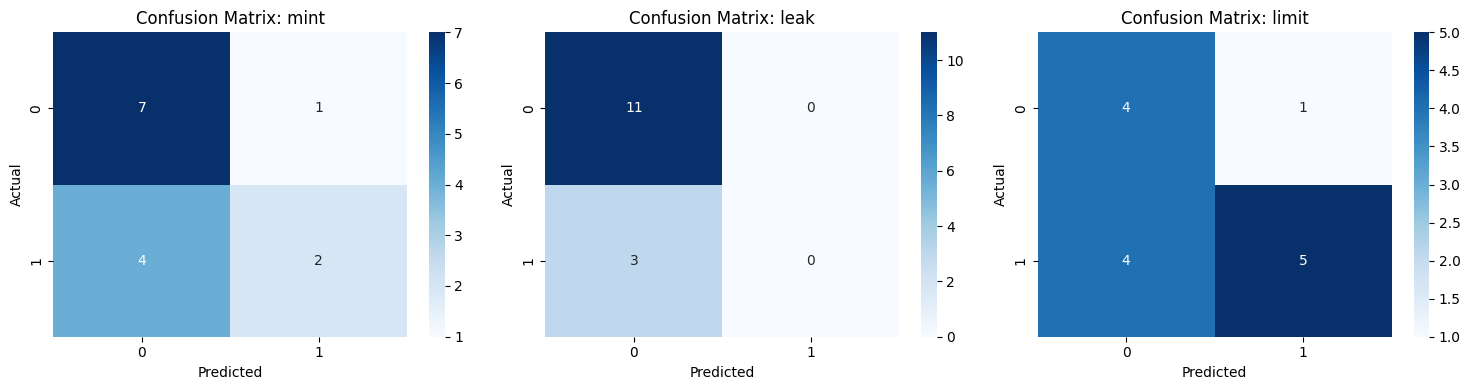

In [24]:
display_multilabel_confusion_matrix(y_test, y_pred)

## MLP

### Build model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError

2025-07-14 00:47:01.145612: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
def Model(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.4),

        Dense(256, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # sigmoid for multi-label
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-6),
        metrics=['accuracy']
    )
    return model

In [27]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])

### Train

In [28]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 782ms/step - accuracy: 0.2604 - loss: 0.7149 - val_accuracy: 0.3636 - val_loss: 1.0440 - learning_rate: 1.0000e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1989 - loss: 0.8239 - val_accuracy: 0.3636 - val_loss: 0.9229 - learning_rate: 1.0000e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3059 - loss: 0.6612 - val_accuracy: 0.4545 - val_loss: 0.8629 - learning_rate: 1.0000e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1837 - loss: 0.6909 - val_accuracy: 0.4545 - val_loss: 0.8275 - learning_rate: 1.0000e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.2140 - loss: 0.7223 - val_accuracy: 0.4545 - val_loss: 0.7981 - learning_rate: 1.0000e-06
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2396 - loss: 0.7093 - val_accuracy: 0.4545 - val_loss: 0.7795 - learning_rate: 1.0000e-06
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.2197 - 

### Predict

In [29]:
y_test_prob = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


In [30]:
def tune_thresholds(y_true, y_pred_prob, metric='f1'):
    y_true = np.asarray(y_true)          # Fix: convert to NumPy
    y_pred_prob = np.asarray(y_pred_prob)

    best_thresholds = []
    best_scores = []

    for i in range(y_true.shape[1]):
        label_true = y_true[:, i]
        label_probs = y_pred_prob[:, i]  # Fix here too

        thresholds = np.linspace(0.0, 1.0, 101)
        scores = []

        for t in thresholds:
            label_pred = (label_probs >= t).astype(int)
            if metric == 'f1':
                score = f1_score(label_true, label_pred, zero_division=0)
            scores.append(score)

        best_t = thresholds[np.argmax(scores)]
        best_score = np.max(scores)

        best_thresholds.append(best_t)
        best_scores.append(best_score)

        print(f"Label {i}: Best threshold = {best_t:.2f}, Best {metric} = {best_score:.4f}")

    return best_thresholds, best_scores


In [31]:
best_thresholds, _ = tune_thresholds(y_test, y_test_prob)

Label 0: Best threshold = 0.23, Best f1 = 0.6667
Label 1: Best threshold = 0.00, Best f1 = 0.3529
Label 2: Best threshold = 0.33, Best f1 = 0.8182


In [32]:
y_pred = (model.predict(X_test) >= best_thresholds).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


### Report

In [33]:
print(classification_report(y_test, y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.50      1.00      0.67         6
        leak       0.21      1.00      0.35         3
       limit       0.69      1.00      0.82         9

   micro avg       0.46      1.00      0.63        18
   macro avg       0.47      1.00      0.61        18
weighted avg       0.55      1.00      0.69        18
 samples avg       0.46      0.71      0.55        18



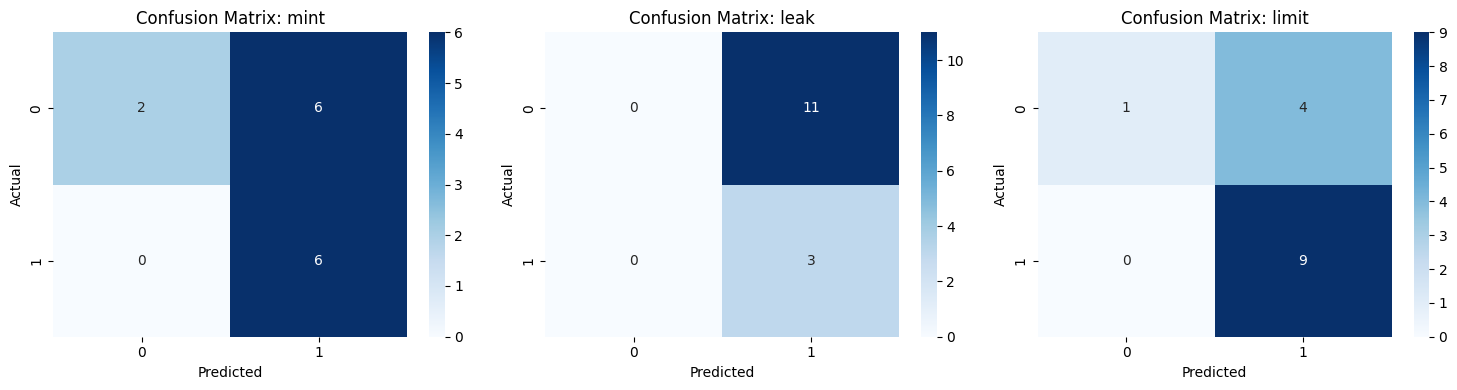

In [34]:
display_multilabel_confusion_matrix(y_test, y_pred)

## Autoencoder + MPL

In [35]:
def Autoencoder(input_dim=256):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128),
        LeakyReLU(0.01),

        Dense(32),
        BatchNormalization(),
        LeakyReLU(0.01),

        Dense(128),
        BatchNormalization(),
        LeakyReLU(0.01),

        Dense(input_dim, activation='sigmoid')  # sigmoid for multi-label
    ])

    model.compile(optimizer=Adam(1e-6), loss=MeanSquaredError())
    return model


In [36]:
autoencoder = Autoencoder(input_dim=X.shape[1])
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - loss: 641.9655 - val_loss: 902.1042
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 761.1899 - val_loss: 902.0952
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 669.5760 - val_loss: 902.0947
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 749.6349 - val_loss: 902.0996
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 769.2711 - val_loss: 902.1028
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 733.7152 - val_loss: 902.1074
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 684.9583 - val_loss: 902.1088
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 696.4173 - val_loss: 902.1119
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 760.1814 - val_loss: 902.1131
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 735.3450 - val_loss: 902.1168
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 687.6891 - val_loss: 902.1186
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [37]:
X_train_encoded = autoencoder.predict(X_train)
X_test_encoded = autoencoder.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [38]:
model = Model(input_dim=X_train_encoded.shape[1], output_dim=y.shape[1])

In [39]:
history = model.fit(X_train_encoded, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 747ms/step - accuracy: 0.2453 - loss: 0.7648 - val_accuracy: 0.0909 - val_loss: 0.7685 - learning_rate: 1.0000e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.1373 - loss: 0.8360 - val_accuracy: 0.0909 - val_loss: 0.7674 - learning_rate: 1.0000e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.0862 - loss: 0.8093 - val_accuracy: 0.0909 - val_loss: 0.7662 - learning_rate: 1.0000e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.2756 - loss: 0.8336 - val_accuracy: 0.0909 - val_loss: 0.7647 - learning_rate: 1.0000e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2292 - loss: 0.7578 - val_accuracy: 0.0909 - val_loss: 0.7634 - learning_rate: 1.0000e-06
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.2500 - loss: 0.7784 - val_accuracy: 0.0909 - val_loss: 0.7619 - learning_rate: 1.0000e-06
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.1023 

In [40]:
y_pred_prob = model.predict(X_test_encoded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


In [41]:
best_thresholds, _ = tune_thresholds(y_test, y_test_prob)

Label 0: Best threshold = 0.23, Best f1 = 0.6667
Label 1: Best threshold = 0.00, Best f1 = 0.3529
Label 2: Best threshold = 0.33, Best f1 = 0.8182


In [42]:
y_pred = (model.predict(X_test) >= best_thresholds).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


### Report

In [43]:
print(classification_report(y_test, y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.00      0.00      0.00         6
        leak       0.21      1.00      0.35         3
       limit       0.00      0.00      0.00         9

   micro avg       0.21      0.17      0.19        18
   macro avg       0.07      0.33      0.12        18
weighted avg       0.04      0.17      0.06        18
 samples avg       0.21      0.10      0.13        18



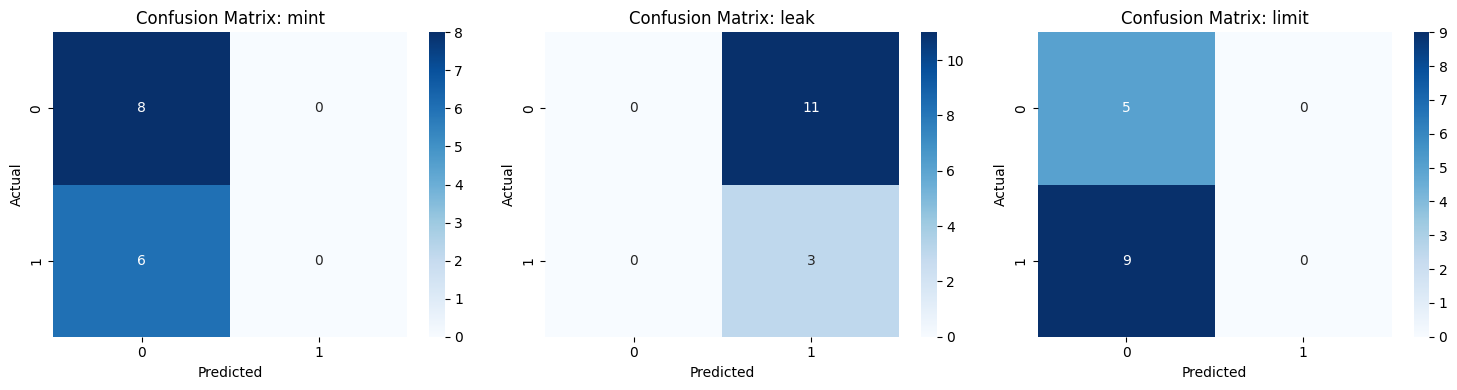

In [44]:
display_multilabel_confusion_matrix(y_test, y_pred)